In [3]:

# ! pip install 'qiskit>=2.1.0' 'qiskit-ibm-runtime>=0.40.1' 'qiskit-aer>=0.17.0' 'numpy' 'pylatexenc'

## Classical coin


Let's start with a classical coin. Toss a coin, and it will land either heads up or heads down, with 50% chance of each. While in principle, one could calculate which side the coin will land on if they knew the precise initial conditions of the coin and the force/torque of the flip, in practice, there is no way to know a priori which side the coin will land on. That's why we use the coin flip as a canonical example of a classical probabilistic state, where the outcome is essentially random. We can write the state of the coin before it lands to reflect this 50/50 probability:

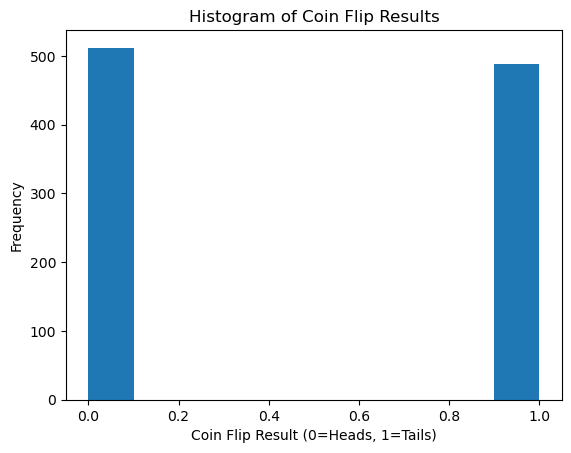

In [4]:
# import necessary packages:
import numpy as np
import matplotlib.pyplot as plt
import random

# number of coin flips
nflips = 1000
fliplist = [random.randint(0, 1) for f in range(nflips)]

plt.hist(fliplist)
plt.xlabel('Coin Flip Result (0=Heads, 1=Tails)')
plt.ylabel('Frequency')
plt.title('Histogram of Coin Flip Results')
plt.show()


## Quantum Coin

Now let's compare our classical coin to a quantum version. In a quantum computer, the basic unit of information is a qubit, which can also be measured in two states: |0⟩ and |1⟩ (analogous to heads and tails).

To create a "quantum coin," we start with a qubit in state |0⟩. By applying a Hadamard gate, we transform it into a superposition state, which can be described as an equal mixture of |0⟩ and |1⟩. When measured, this quantum coin will give |0⟩ or |1⟩ with equal probability—much like our fair coin flip.

However, there's a crucial difference: although the outcomes look similar at first, a quantum superposition is fundamentally different from a classical probabilistic state. We'll explore what sets them apart as we continue.


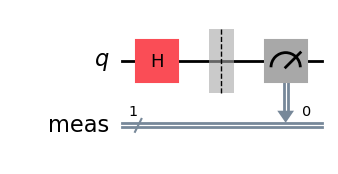

In [20]:
from qiskit import QuantumCircuit
 
qcoin = QuantumCircuit(1)
qcoin.h(0)
res = qcoin.measure_all()


# Draw the circuit with labeled gates
qcoin.draw("mpl", style='iqp')

 - Applying the Hadamard gate to a qubit acts as the quantum analogue of flipping a coin.
 - For classical coins, we flipped the coin 1000 times and recorded the statistics of heads and tails.
 - Similarly, in Qiskit, we can repeat our "quantum coin" experiment many times to gather measurement statistics.
 - This is done using Qiskit's Sampler primitive, which executes a circuit multiple times to sample the outcomes.


In [21]:
# Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Load saved credentials
service = QiskitRuntimeService()


qiskit_runtime_service.__init__:WARNING:2025-12-06 12:00:24,546: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


In [22]:
# Load the Runtime primitive and session
from qiskit_ibm_runtime import (
    SamplerV2 as Sampler,
    EstimatorV2 as Estimator,
)
 
# Use the least busy backend
backend = service.least_busy()
print(backend.name)

qiskit_runtime_service.backends:WARNING:2025-12-06 12:00:24,986: Using instance: open-instance, plan: open


ibm_fez


In Qiskit, a "transpiler" is a tool that translates a high-level quantum circuit (which is hardware-agnostic) into a new circuit that is optimized for a specific quantum device (backend). 
Each quantum computer has its own set of available gates and connectivity between qubits—
the transpiler rewrites your circuit to obey these constraints and tries to optimize it to run more efficiently.
This often means reducing the circuit depth or number of gates, which matters for real hardware.

In [23]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Get the target configuration (native gate set and connectivity) for our backend
target = backend.target

# Create the preset pass manager with a high optimization level
pm = generate_preset_pass_manager(target=target, optimization_level=3)

# Run the transpiler on our quantum coin circuit to map it to the hardware
qc_isa = pm.run(qcoin)

In [24]:
## Execute
 
# On real hardware:
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs, shots=1000)
res = job.result()
 
counts = res[0].data.meas.get_counts()
 
# or with Aer simulator with noise model from real backend
# job = sampler_sim.run([qc_isa])
# counts=job.result()[0].data.meas.get_counts()

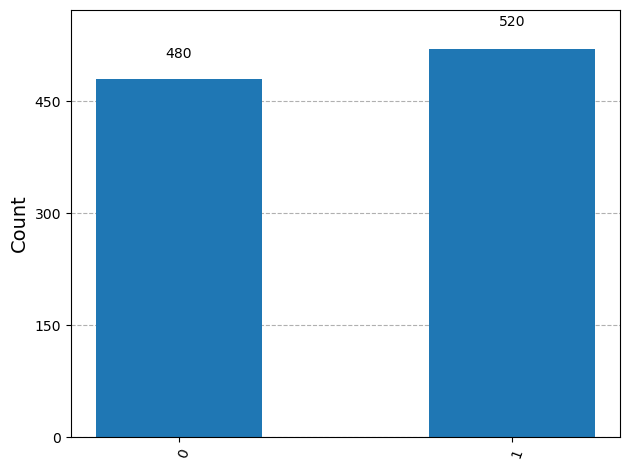

In [25]:
## Analysis
from qiskit.visualization import plot_histogram
 
plot_histogram(counts)

In [26]:
from qiskit.quantum_info import Pauli
 
qcoin = QuantumCircuit(1)
qcoin.h(0)
 
# for Estimator, we do not apply the measurement to the circuit

In [27]:
## Transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
obs = Pauli("Z")
 
qc_isa = pm.run(qcoin)
obs_isa = obs.apply_layout(layout=qc_isa.layout)

In [28]:
## Execute
 
# On real hardware:
estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
job = estimator.run([[qc_isa, obs_isa]])
res = job.result()
 
# On a simulator:
# job = estimator_sim.run([[qc_isa, obs_isa]])
# res=job.result()
 
print(res[0].data.evs)

0.020942408376963352


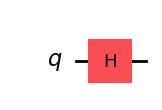

In [29]:
# Step 1: map problem
 
qcoin_lr = QuantumCircuit(1)
qcoin_lr.h(0)
 
# This line defines the observable (measured operator) as the Pauli X operator for later expectation value estimation.
obs = Pauli("X")

qcoin.draw("mpl", style='iqp')



In [30]:
# Step 2: Transpile the circuit
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qcoin_lr)
obs_isa = obs.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
job = estimator.run([[qc_isa, obs_isa]])
res = job.result()


In [ ]:
print(res[0].data.evs)

0.9990034877927254


What is going on here? It seems like our quantum coin can have random, probabilistic outcomes along one dimension, but perfectly predictable outcomes along another. That would be like flipping a coin and guaranteeing that every time it was caught by sandwiching it between two hands, it would end up with the head facing the right.




 ## The quantum phase
 
 - Key difference of a quantum coin vs classical coin: the quantum coin has "phase", an extra property that classical coins lack.
 - In a classical probabilistic system:
   - The state can be written as $S_{\text{coin}} = c_1\,|\text{up}\rangle + c_2\,|\text{down}\rangle$.
   - Here, $c_1$ and $c_2$ are real, positive numbers representing the probability of being in the $|\text{up}\rangle$ or $|\text{down}\rangle$ state.
 - In a quantum system:
   - The state is $|\psi\rangle = c_1\,|0\rangle + c_2\,|1\rangle$.
   - Now, $c_1$ and $c_2$ can be complex numbers (with both real and imaginary parts).
 - Each quantum coefficient $c_i$:
   - Can be visualized as a vector in the complex plane.
   - Has a magnitude $|c_i|$ (distance from the origin).
   - Has an angle (phase) $\phi_i$ it makes with the real axis.
 - The phase of these complex numbers affects quantum phenomena like interference — an effect with no analog in classical probability.
 


 - The parameter $\varphi_i$ is called the *phase* of a quantum state.
 - The phase determines how two terms in a quantum state will interfere with one another—whether they will add up (constructive interference) or cancel each other (destructive interference).
 - If two quantum states (or waves) are *in phase* (their crests and troughs line up), they combine to form a larger amplitude (constructive interference).
 - If they are *out of phase* (a crest lines up with a trough), they can cancel each other out completely (destructive interference).
 - Quantum states, like waves, can interfere both constructively and destructively, but unlike physical waves, this interference often happens in the abstract "information space" of qubits (the Hilbert space, where states like $\lvert \psi \rangle = c_1 \lvert 0 \rangle + c_2 \lvert 1 \rangle$ live).
 - Only the *relative phase* between coefficients matters for interference. The difference in phases $\Delta\varphi = \varphi_2 - \varphi_1$ determines the interference pattern.
 - Typically, we can adjust the global phase so that $c_1$ is purely real, and all relative phase information is in $c_2$.
 - To see phase interference in action for a quantum coin, apply the Hadamard gate twice in a row to the same qubit.
   - Classically, flipping a coin twice doesn't make sense, but in quantum mechanics, applying Hadamard twice has a specific, non-trivial effect on the state due to phase.

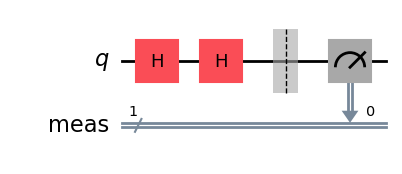

In [ ]:
qcoin_0 = QuantumCircuit(1)
qcoin_0.h(0)
qcoin_0.h(0)
qcoin_0.measure_all()
 
qcoin_0.draw("mpl")

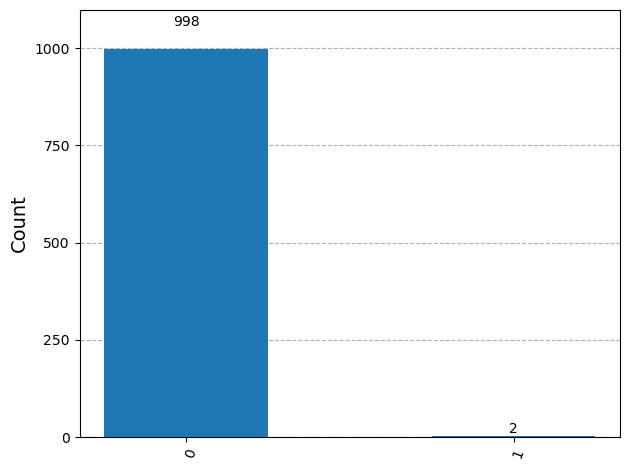

In [ ]:
## Transpile
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
qc_isa = pm.run(qcoin_0)
 
## Execute
 
# On real hardware:
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs, shots=1000)
res = job.result()
 
counts = res[0].data.meas.get_counts()
  
 
# or with Aer simulator with noise model from real backend
# job = sampler_sim.run([qc_isa])
# counts=job.res ult()[0].data.meas.get_counts()
 
## Analyze
plot_histogram(counts)

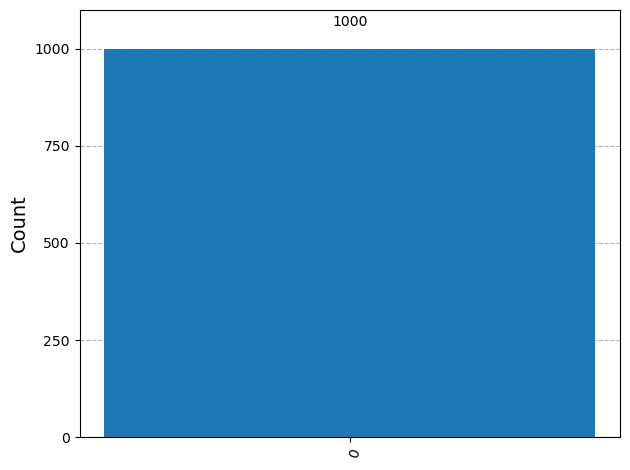

In [34]:
## Transpile
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
qc_isa = pm.run(qcoin_0)
 
## Execute
 
# On real hardware:
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs, shots=1000)
res = job.result()
 
counts = res[0].data.meas.get_counts()
 
 
# or with Aer simulator with noise model from real backend
# job = sampler_sim.run([qc_isa])
# counts=job.result()[0].data.meas.get_counts()
 
## Analyze
plot_histogram(counts)

- The second Hadamard gate cancels out the first, returning the qubit to the |0⟩ state.
- The Hadamard gate transforms the states as follows:
    - H|0⟩ = (|0⟩ + |1⟩)/√2
    - H|1⟩ = (|0⟩ - |1⟩)/√2
- Applying two Hadamard gates in sequence:
    - H(H|0⟩) = H((|0⟩ + |1⟩)/√2)
    - = (H|0⟩ + H|1⟩)/√2
    - = ((|0⟩ + |1⟩)/√2 + (|0⟩ - |1⟩)/√2)/√2
    - = (2|0⟩)/2 = |0⟩
- Thus, after the second Hadamard, the |0⟩ terms add up (constructive interference) and the |1⟩ terms cancel out (destructive interference), leaving only |0⟩.


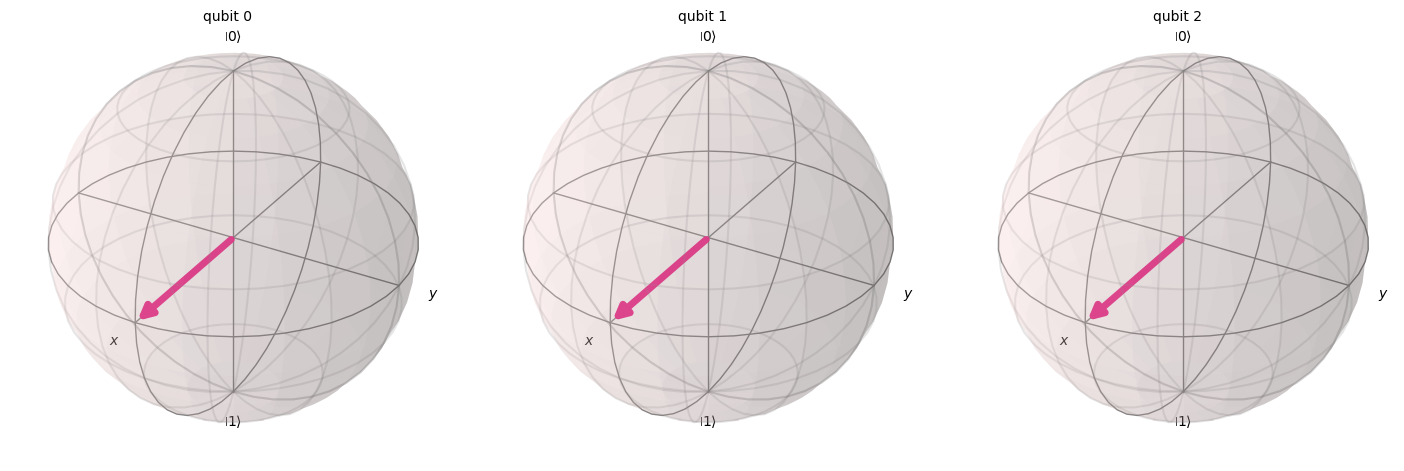

In [35]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector

# Create a 3-qubit quantum circuit
qc = QuantumCircuit(3)

# Apply Hadamard gate to all three qubits
qc.h(0)
qc.h(1)
qc.h(2)

# Visualize the circuit
qc.draw("mpl")

# Optional: Show the resulting statevector and its Bloch representation
state = Statevector.from_instruction(qc)
plot_bloch_multivector(state)


Let's explore further by introducing a phase shift using the "PHASE" gate.
We'll apply a Hadamard gate to create superposition,
then a phase shift of π radians,
then apply a second Hadamard gate.

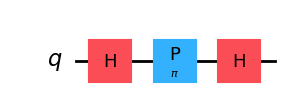

In [40]:
qcoin_pi = QuantumCircuit(1)
qcoin_pi.h(0)
qcoin_pi.p(np.pi, 0)
qcoin_pi.h(0)
# qcoin_pi.measure_all()
 
qcoin_pi.draw("mpl")


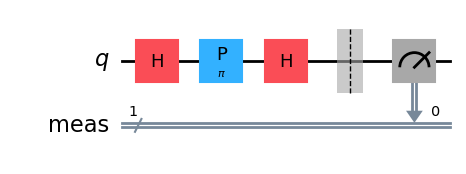

In [41]:
qcoin_pi = QuantumCircuit(1)
qcoin_pi.h(0)
qcoin_pi.p(np.pi, 0)
qcoin_pi.h(0)
qcoin_pi.measure_all()
 
qcoin_pi.draw("mpl")